In [77]:
import matplotlib.pyplot as plt
import copy
import matplotlib.animation as animation
import numpy as np
import os
import math
import time

In [230]:
def read_maze(file_name):
    with open(file_name, "r") as f:
        n = int(f.readline())

        plus_point = [] #read list of plus point
        for i in range(n):
            point = [int(x) for x in f.readline().split(' ')]
            point[2] = -point[2]
            plus_point.append(point)

        maze = [] #read maze
        for line in f:
            if line[-1] == '\n': line = line[:-1]
            maze.append([x for x in line])

        for point in plus_point: #embed plus point to maze
            maze[point[0]][point[1]] = point[2]

        for i,x in enumerate(maze[0]): 
            if x == ' ': maze[0][i] = 'G'
        for i,x in enumerate(maze[-1]): 
            if x == ' ': maze[-1][i] = 'G'
        for line in maze[1:-1]:
            if line[0] == ' ': line[0] = 'G'
            if line[-1] == ' ': line[-1] = 'G'
        
        return maze
        
def encode_char(char):
    if char == 'x': return 0
    if char == 'S': return 255
    if char == ' ': return 170
    if char == 'P': return 235
    if char == 'V': return 200
    if char == 'O': return 220
    if char == 'G': return 240
    return 120 - int(char) * 9

def upscale(maze, scale):
    new_maze = np.zeros([np.shape(maze)[0] * scale, np.shape(maze)[1] * scale])
    for i in range(np.shape(maze)[0]):
        for j in range(np.shape(maze)[1]):
            new_maze[i * scale : (i + 1) * scale, j * scale : (j + 1) * scale] = maze[i][j]
    return new_maze

def update_maze(maze, frontier, visited, path, start, goal):
    #update maze status after each iteration
    new_maze = copy.deepcopy(maze)
    for i in range(len(new_maze)):
        for j in range(len(new_maze[i])):
            if [i, j] in [x[0:2] for x in visited]:
                if len(path) == 0:
                    new_maze[i][j] = 'V'
                else: new_maze[i][j] = ' '
            if [i, j] in [x[0:2] for x in frontier]:
                if len(path) == 0:
                    new_maze[i][j] = 'O'
                else: new_maze[i][j] = ' '
            if [i, j] in [x[0:2] for x in path]:
                new_maze[i][j] = 'P'
            if [i, j] == start[0:2]:
                new_maze[i][j] = 'S'
            if [i, j] == goal[0:2]:
                new_maze[i][j] = 'G'
    return new_maze

def get_neighbors(current, maze):
    neighbors = []
    if current[0] > 0:
        neighbors.append([current[0] - 1, current[1]])
    if current[0] < len(maze) - 1:
        neighbors.append([current[0] + 1, current[1]])
    if current[1] > 0:
        neighbors.append([current[0], current[1] - 1])
    if current[1] < len(maze[0]) - 1:
        neighbors.append([current[0], current[1] + 1])

    return neighbors

def tracing(trace, goal, start):
    path = []
    current = goal
    while current != start:
        path.append(current)
        current = trace[current[0]][current[1]]
    return path

def find_start_goal(maze):
    start = [0, 0]
    goal = [0, 0]
    #find start and goal point
    for i in range(len(maze)):
        for j in range(len(maze[i])):
            if maze[i][j] == 'S':
                start = [i, j]
            if maze[i][j] == 'G':
                goal = [i, j]
    return start, goal

def init_search(maze):
    start, goal = find_start_goal(maze)
    frontier = [start]
    visited = [] 
    path = []
    trace = [[[0,0] for i in range(len(maze[0]))] for j in range(len(maze))]
    iter_maze = [maze]
    return start, goal, frontier, visited, path, trace, iter_maze

def save_maze(maze, folder_name, file_name):
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

    encoded_maze = [list(map(encode_char, line)) for line in maze]
    upscaled_maze = upscale(encoded_maze, 100)

    plt.xticks(color = 'w')
    plt.yticks(color = 'w')
    plt.tick_params(bottom = False, left = False)

    plt.imsave(folder_name + '/' + file_name, upscaled_maze, cmap = 'rainbow')

def manhattan_distance(a, b):
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

def euclidean_distance(a, b):
    return math.sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2)

def chebyshev_distance(a, b):
    return max(abs(a[0] - b[0]), abs(a[1] - b[1]))

def sum_distance(a, b):
    return manhattan_distance(a, b) + euclidean_distance(a, b)

def nothing(a, b):
    return 0

def dfs(maze):
    start, goal, frontier, visited, path, trace, iter_maze = init_search(maze)

    def recursion(step, current, goal, frontier, visited, path, trace, iter_maze):
        visited.append(current)
        if current == goal:
            path = tracing(trace, goal, start)
            new_iter_maze = copy.deepcopy(iter_maze)
            new_iter_maze.append(update_maze(maze, frontier, visited, path, start, goal))
            return new_iter_maze, path

        for neighbor in get_neighbors(current, maze):
            if neighbor not in visited and neighbor not in frontier and maze[neighbor[0]][neighbor[1]] != 'x':
                frontier.append(neighbor)
                trace[neighbor[0]][neighbor[1]] = current
                new_iter_maze = copy.deepcopy(iter_maze)
                new_iter_maze.append(update_maze(maze, frontier, visited, path, start, goal))
                find_next = recursion(step + 1, neighbor, goal, frontier, visited, path, trace, new_iter_maze)
                if find_next is not None: return find_next

        if step == 0: return 'NO'

    return(recursion(0, start, goal, frontier, visited, path, trace, iter_maze))

def bfs(maze):
    start, goal, frontier, visited, path, trace, iter_maze = init_search(maze)

    #loop until stack is empty
    while len(frontier) > 0:
        current = frontier.pop(0)
        visited.append(current)
        #if reach goal
        if current == goal:
            path = tracing(trace, goal, start)
            iter_maze.append(update_maze(maze, frontier, visited, path, start, goal))
            return iter_maze, path
        
        for neighbor in get_neighbors(current, maze):
            #if neighbor is not visited and not a wall
            if neighbor not in visited and neighbor not in frontier and maze[neighbor[0]][neighbor[1]] != 'x':
                frontier.append(neighbor)
                trace[neighbor[0]][neighbor[1]] = current
                
        iter_maze.append(update_maze(maze, frontier, visited, path, start, goal))

    return 'NO'

def ucs(maze):
    start, goal, frontier, visited, path, trace, iter_maze = init_search(maze)
    f = [[1000000 for i in range(len(maze[0]))] for j in range(len(maze))]
    f[start[0]][start[1]] = 0

    def push(pq, new_item):
        i = len(pq) - 1
        while i >= 0:
            if f[new_item[0]][new_item[1]] >= f[pq[i][0]][pq[i][1]]:
                break
            i -= 1
        pq.insert(i + 1, new_item)
            
    while len(frontier) > 0:
        current = frontier.pop(0)
        visited.append(current)
        if current == goal: 
            path = tracing(trace, goal, start)
            iter_maze.append(update_maze(maze, frontier, visited, path, start, goal))
            return iter_maze, path
            break

        for neighbor in get_neighbors(current, maze):
            if neighbor not in visited and maze[neighbor[0]][neighbor[1]] != 'x':
                temp_dis = f[current[0]][current[1]] + 1
                if temp_dis < f[neighbor[0]][neighbor[1]]:
                    f[neighbor[0]][neighbor[1]] = temp_dis
                    trace[neighbor[0]][neighbor[1]] = current
                    push(frontier, neighbor)

        iter_maze.append(update_maze(maze, frontier, visited, path, start, goal))

    return 'NO'

def gbfs(maze, heuristic):
    start, goal, frontier, visited, path, trace, iter_maze = init_search(maze)
    f = [[eval(heuristic)([j, i], goal) for i in range(len(maze[0]))] for j in range(len(maze))]

    def push(pq, new_item):
        i = len(pq) - 1
        while i >= 0:
            if f[new_item[0]][new_item[1]] >= f[pq[i][0]][pq[i][1]]:
                break
            i -= 1
        pq.insert(i + 1, new_item)

    while len(frontier) > 0:
        current = frontier.pop(0)
        visited.append(current)
        if current == goal:
            path = tracing(trace, goal, start)
            iter_maze.append(update_maze(maze, frontier, visited, path, start, goal))
            return iter_maze, path

        for neighbor in get_neighbors(current, maze):
            #if neighbor is not visited and not a wall
            if neighbor not in visited and neighbor not in frontier and maze[neighbor[0]][neighbor[1]] != 'x':
                push(frontier, neighbor)
                trace[neighbor[0]][neighbor[1]] = current

        iter_maze.append(update_maze(maze, frontier, visited, path, start, goal))
    
    return 'NO'

def astar(maze, heuristic):
    start, goal, frontier, visited, path, trace, iter_maze = init_search(maze)
    g = [[0 for i in range(len(maze[0]))] for j in range(len(maze))]
    g[start[0]][start[1]] = 0
    h = [[eval(heuristic)([j, i], goal) for i in range(len(maze[0]))] for j in range(len(maze))]

    def push(pq, new_item):
        i = len(pq) - 1
        while i >= 0:
            if g[new_item[0]][new_item[1]] + h[new_item[0]][new_item[1]] >= g[pq[i][0]][pq[i][1]] + h[pq[i][0]][pq[i][1]]:
                break
            i -= 1
        pq.insert(i + 1, new_item)

    while len(frontier) > 0:
        current = frontier.pop(0)
        visited.append(current)

        if current == goal:
            path = tracing(trace, goal, start)
            iter_maze.append(update_maze(maze, frontier, visited, path, start, goal))
            return iter_maze, path

        for neighbor in get_neighbors(current, maze):
            #if neighbor is not visited and not a wall
            if neighbor not in visited and neighbor not in frontier and maze[neighbor[0]][neighbor[1]] != 'x':
                g[neighbor[0]][neighbor[1]] = g[current[0]][current[1]] + 1
                push(frontier, neighbor)
                trace[neighbor[0]][neighbor[1]] = current
                
        iter_maze.append(update_maze(maze, frontier, visited, path, start, goal))
    
    return 'NO'

def compare_algo(maze):
    no_info_search_algo = ['dfs', 'bfs', 'ucs']
    res = [dfs(maze), bfs(maze), ucs(maze)]

    info_search_algo = ['gbfs', 'astar']
    heuristic = ['manhattan_distance', 'euclidean_distance', 'chebyshev_distance']

    all_algo = []
    all_algo.extend(no_info_search_algo)

    for algo in info_search_algo:
        for h in heuristic:
            res.append(eval(algo)(maze, h))
            all_algo.append(algo + '_' + h[:3])

    weight = 0
    if len(res) % 3 == 0:
        weight = len(res) // 3
    else:
        weight = len(res) // 3 + 1

    fig, axes = plt.subplots(3, weight, figsize = (weight * 3, 9))

    for i in range(len(res)):
        encoded_maze = [list(map(encode_char, line)) for line in res[i][0][-1]]
        axes[i // 3, i % 3].imshow(encoded_maze, cmap = 'rainbow')
        axes[i // 3, i % 3].set_title(all_algo[i] + ': ' + str(len(res[i][1])))

        axes[i // 3, i % 3].xaxis.set_visible(False)
        axes[i // 3, i % 3].yaxis.set_visible(False)

def show_maze(maze):
    encoded_maze = [list(map(encode_char, line)) for line in maze]

    fig, ax = plt.subplots(figsize = (len(encoded_maze), len(encoded_maze[0])))
    plt.xticks(color = 'w')
    plt.yticks(color = 'w')
    plt.tick_params(bottom = False, left = False)

    plt.imshow(encoded_maze, cmap = 'rainbow')


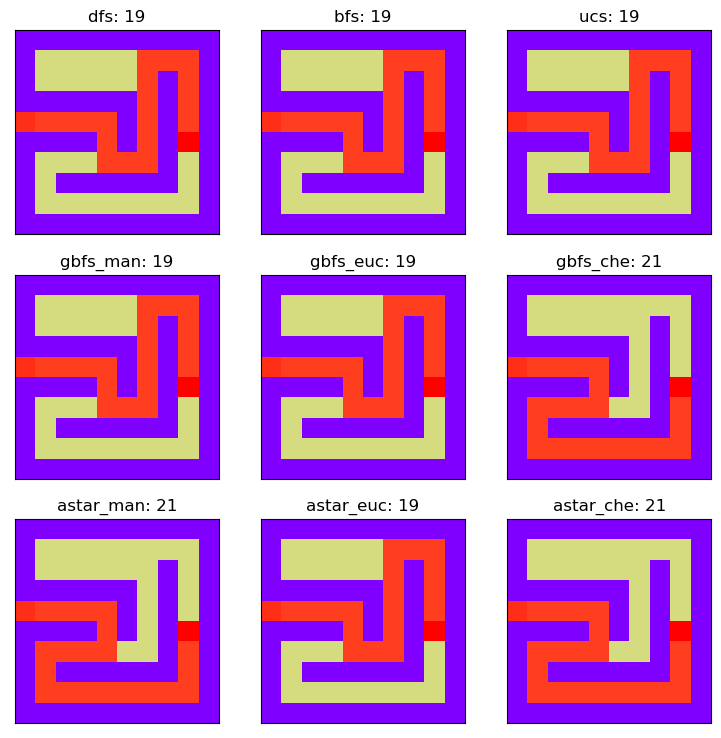

In [232]:
cwd = os.path.dirname(os.getcwd())
file_name = cwd + '/input/level__1/input2.txt'
maze = read_maze(file_name)

compare_algo(maze)